In [132]:
from __future__ import print_function, division
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os
from bs4 import BeautifulSoup
import re
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [2]:
#initiate driver window
chromedriver = "/Applications/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)
url = 'https://www.gameinformer.com/reviews'
driver.get(url)

In [9]:
page_counter = 1
count_down = 150 #120 pages as of 7/18/2018

# loop this a bunch of times w a time element to pause
while count_down > 0:
    try:
        next_page_button=driver.find_element_by_xpath('//*[@id="block-gi5-content"]/div/div/ul/li/a')
        next_page_button.click()
        page_counter = page_counter+1
    except:
        print("Loaded",page_counter,"pages")
    
    count_down = count_down -1
    print(count_down)    
    
    time.sleep(random.randint(6,10)) #wired at 6-10s; wi-fi was 25-40 at Metis
   

249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
Loaded 120 pages
130
Loaded 120 pages
129
Loaded 120 pages
128
Loaded 120 pages
127
Loaded 120 pages
126
Loaded 120 pages
125
Loaded 120 pages
124
Loaded 120 pages
123
Loaded 120 pages
122
Loaded 120 pages
121
Loaded 120 pages
120
Loaded 120 pages
119
Loaded 120 pages
118
Loaded 120 pages
117
Loaded 120 pages
116
Loaded 120 pages
115
Loaded 120 pages
114
Loaded 120 pages
113
Loaded 120 pages
112
Loaded 120 pages
111
Loaded 120 pages
110
Loaded 120 pages
109
Loaded 120 pages
108
Loaded 120 pages
107
Loaded 120 pages
106

In [3]:
soup = BeautifulSoup(driver.page_source, "lxml")

# But we are missing some of the scores....}

In [4]:
elements = soup.find_all("div", class_="teaser-left".split()) #grab all the scores & null

In [5]:
#loop through elements, for errors substitute 5.0 (neutral score)
scores=[]
for el in elements:
    try: 
        scores.append(float(el.find("div",{"class":"score"}).get_text().strip()))
    except:
        scores.append(5.0)

In [6]:
#scrape the titles and dates

titles = soup.find_all("h2",{"class":"page-title"})
titles = [title.get_text().strip() for title in titles]

author_dates = soup.find_all("div",{"class":"author-details"})
author_dates = [author.get_text().replace('\t','').replace('\n',' ').replace('\xa0','') for author in author_dates]

#clean strings
start = ''
end = ' Review'
titles  = [re.search('%s(.*)%s' % (start, end),title) for title in titles]

start = 'by '
end = ' on'
authors  = [re.search('%s(.*)%s' % (start, end),author).group(1) for author in author_dates]

start = 'on '
end = ' at'
dates  = [re.search('%s(.*)%s' % (start, end),date).group(1) for date in author_dates]

In [7]:
#trim dates to 12 characters on right
dates_clean = []
for item in dates:
    if len(item)==12:
        dates_clean.append(item)
    else:
        dates_clean.append(item[-12:])

In [8]:
#handle missing titles
newlist=[]
start = ''
end = ' Review'
for title in titles:
    try:
        newlist.append(title.group(1))
    except:
        newlist.append('Missing')

titles = newlist
print(dates)

['Jul 18, 2018', 'Jul 18, 2018', 'Jul 19, 2018', 'Jul 18, 2018', 'Jul 17, 2018', 'Jul 13, 2018', 'Jul 13, 2018', 'Jul 09, 2018', 'Jul 02, 2018', 'Jul 02, 2018', 'Jun 29, 2018', 'Jun 27, 2018', 'Jun 25, 2018', 'Jun 22, 2018', 'Jun 22, 2018', 'Jun 19, 2018', 'Jun 19, 2018', 'Jun 16, 2018', 'Jun 09, 2018', 'Jun 07, 2018', 'Jun 04, 2018', 'Jun 04, 2018']


In [129]:
#saved 120 pages of scraped data to csv 7/18/18
#reviews.to_csv('reviews.csv',index=False)

In [9]:
#if you need to reload data from CSV:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,Date,Score,Title
0,"Jul 17, 2018",6.0,Adventure Time: Pirates Of The Enchiridion
1,"Jul 17, 2018",6.0,Adventure Time: Pirates Of The Enchiridion
2,"Jul 17, 2018",6.0,Adventure Time: Pirates Of The Enchiridion
3,"Jul 13, 2018",5.0,Earthfall
4,"Jul 13, 2018",8.0,Captain Toad: Treasure Tracker


In [10]:
class HTMLTableParser:
   
    def parse_url(self, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        return [(table['id'],self.parse_html_table(table))\
                for table in soup.find_all('table')]  
    
    def parse_soup(self, soup):
        return [(table['id'],self.parse_html_table(table))\
                for table in soup.find_all('table')]  

    def parse_html_table(self, table):
        n_columns = 0
        n_rows=0
        column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        for row in table.find_all('tr'):
            
            # Determine the number of rows in the table
            td_tags = row.find_all('td')
            if len(td_tags) > 0:
                n_rows+=1
                if n_columns == 0:
                    # Set the number of columns for our table
                    n_columns = len(td_tags)
                    
            # Handle column names if we find them
            th_tags = row.find_all('th') 
            if len(th_tags) > 0 and len(column_names) == 0:
                for th in th_tags:
                    column_names.append(th.get_text())

        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0
        for row in table.find_all('tr'):
            column_marker = 0
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker,column_marker] = column.get_text()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1
                
        # Convert to float if possible
        for col in df:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass
        
        return df

In [11]:
# Scrape legacy table data
url = 'https://gi9641r1.cachefly.net/reviewsarchive/review-archive-legacy-pantheon14.html'
driver.get(url)
soup_level1=BeautifulSoup(driver.page_source, 'lxml')
hp = HTMLTableParser()
legacy_table = hp.parse_soup(soup_level1)[0][1] # Grabbing the table from the tuple

EA publisher data: https://en.wikipedia.org/wiki/List_of_Electronic_Arts_games

EA & SPX stock data: https://finance.yahoo.com/quote/

In [16]:
#import game list from wikipedia scrapes
games = pd.read_csv('games.csv')

In [17]:
#drop excess columns
less_legacy =legacy_table.copy(deep=True)
less_legacy['Date']=less_legacy['Issue']
less_legacy=less_legacy.drop(columns=['Issue','Platform'])

In [18]:
less_legacy['Date']= pd.to_datetime(less_legacy['Date'])

In [38]:
#Focusing on EA games due to stock liquidity, market cap, and depth of data
less_games = games.drop(columns=['Platform','Date'])
    EA_games = games.drop(columns=['Year','Date'])
EA_games = less_games.loc[less_games['Publisher'] == 'EA']
EA_games

,Publisher,Title
1575,EA,Archon: The Light and the Dark
1576,EA,Archon: The Light and the Dark
1577,EA,Archon: The Light and the Dark
1578,EA,Archon: The Light and the Dark
1579,EA,Archon: The Light and the Dark
1580,EA,Archon: The Light and the Dark
1581,EA,Archon: The Light and the Dark
1582,EA,Archon: The Light and the Dark
1583,EA,Archon: The Light and the Dark
1584,EA,Archon: The Light and the Dark


In [39]:
# stack the DataFrames on top of each other so we can drop dupes from top to bottom
all_reviews = pd.concat([reviews, less_legacy], axis=0)

In [40]:
#Get rid of dupes from the two gameinformer's datasets
clean_reviews = all_reviews.drop_duplicates(subset='Title',keep='first')

#Get rid of dupes from multiple-platform entries in less_games
clean_EA = EA_games.drop_duplicates(subset='Title',keep='first')

In [41]:
#dropped 3k dupe-reviews; 4k dupe-games
clean_reviews.shape

(7551, 3)

In [42]:
pd.to_datetime(clean_reviews['Date'], errors='coerce');

In [43]:
clean_reviews.Title.value_counts()  #result looks reasonable from a single source (gameinformer)
clean_EA.Title.value_counts() #only public company's games

NBA Live 07                                   1
UEFA Euro 2008                                1
The Beatles: Rock Band                        1
Skitchin'                                     1
Command & Conquer 4: Tiberian Twilight        1
Need for Speed: V-Rally                       1
The Sims 2: FreeTime                          1
Battlefield Vietnam                           1
The Sims 2: Open for Business                 1
NASCAR 2005: Chase for the Cup                1
FIFA Manager 14                               1
Fantasy Safari                                1
Bundesliga 99                                 1
Crysis Warhead                                1
The Sims                                      1
NFL Street 2 Unleashed                        1
Ultima Online                                 1
NHL 08                                        1
SimCity 3000 World Edition                    1
Mail Order Monsters                           1
Command & Conquer                       

In [44]:
#clean_reviews = consolidated gameinformer reviews
#clean_EA = games by EA
#inner join to keep only games w/ reviews by specific publishers
merged_reviews = pd.merge(clean_reviews, clean_EA, how = 'inner',on='Title')   #Only EA games w/ reviews

In [45]:
merged_reviews['Date'] = pd.to_datetime(merged_reviews['Date'])
merged_reviews = merged_reviews[pd.notnull(merged_reviews['Publisher'])]
merged_reviews

,Date,Score,Title,Publisher
0,2018-06-22,8,Unravel Two,EA
1,2018-03-22,7,A Way Out,EA
2,2018-02-19,5.5,Fe,EA
3,2017-11-14,6.5,Star Wars Battlefront II,EA
4,2017-09-25,7,NBA Live 18,EA
5,2017-09-21,8.75,FIFA 18,EA
6,2017-09-12,8,NHL 18,EA
7,2017-03-19,8,Mass Effect: Andromeda,EA
8,2016-10-24,9.5,Titanfall 2,EA
9,2016-10-21,9.25,Battlefield 1,EA


In [46]:
#import EA stock data; Data has been extended to account accurately for market closures.
EA = pd.read_csv('EA.csv')

In [47]:
EA['Date'] = pd.to_datetime(EA['Date'])
EA = EA.drop(columns=['Publisher'])

In [48]:
merged_reviews = merged_reviews.drop(columns=['Publisher'])

In [49]:
EA.head()

,Date,Close,Volume,Stock+7,Stock+30,rel_return_7d,rel_return_30d
0,2018-06-16,146.65,3943808.0,141.26,146.68,-2.81,-0.78
1,2018-06-15,146.65,3943808.0,141.26,148.73,-2.81,0.53
2,2018-06-14,144.39,4558765.0,143.15,148.73,0.75,2.70
3,2018-06-13,143.28,6432883.0,143.54,148.73,0.92,3.24
4,2018-06-12,139.78,2902051.0,143.09,148.61,3.59,6.16


In [50]:
merged_reviews.head()

,Date,Score,Title
0,2018-06-22,8,Unravel Two
1,2018-03-22,7,A Way Out
2,2018-02-19,5.5,Fe
3,2017-11-14,6.5,Star Wars Battlefront II
4,2017-09-25,7,NBA Live 18


In [51]:
data = pd.merge(merged_reviews, EA, on=['Date'], how ="left")  
data.head()

,Date,Score,Title,Close,Volume,Stock+7,Stock+30,rel_return_7d,rel_return_30d
0,2018-06-22,8,Unravel Two,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-03-22,7,A Way Out,122.98,2726954.0,121.24,120.89,-1.22,-2.81
2,2018-02-19,5.5,Fe,126.02,3214545.0,128.57,126.00,0.27,0.97
3,2017-11-14,6.5,Star Wars Battlefront II,112.27,3618044.0,107.71,106.42,-4.94,-8.29
4,2017-09-25,7,NBA Live 18,114.20,4113093.0,117.95,114.56,1.92,-2.24


In [52]:
data = data.drop(0, axis=0) #6/22/18 out of range
data.head()

,Date,Score,Title,Close,Volume,Stock+7,Stock+30,rel_return_7d,rel_return_30d
1,2018-03-22,7,A Way Out,122.98,2726954.0,121.24,120.89,-1.22,-2.81
2,2018-02-19,5.5,Fe,126.02,3214545.0,128.57,126.00,0.27,0.97
3,2017-11-14,6.5,Star Wars Battlefront II,112.27,3618044.0,107.71,106.42,-4.94,-8.29
4,2017-09-25,7,NBA Live 18,114.20,4113093.0,117.95,114.56,1.92,-2.24
5,2017-09-21,8.75,FIFA 18,118.02,1914374.0,116.61,113.62,-1.58,-6.82


In [53]:
data['moving_avg_30d'] = data['Score'].rolling(window=30,min_periods=1 ).mean()

In [54]:
data['Score']=pd.to_numeric(data['Score'])

In [55]:
data['good_bad'] = data['Score']//5 #binary review score; <6 is bad
data.head()

,Date,Score,Title,Close,Volume,Stock+7,Stock+30,rel_return_7d,rel_return_30d,moving_avg_30d,good_bad
1,2018-03-22,7.00,A Way Out,122.98,2726954.0,121.24,120.89,-1.22,-2.81,7.000000,1.0
2,2018-02-19,5.50,Fe,126.02,3214545.0,128.57,126.00,0.27,0.97,6.250000,1.0
3,2017-11-14,6.50,Star Wars Battlefront II,112.27,3618044.0,107.71,106.42,-4.94,-8.29,6.333333,1.0
4,2017-09-25,7.00,NBA Live 18,114.20,4113093.0,117.95,114.56,1.92,-2.24,6.500000,1.0
5,2017-09-21,8.75,FIFA 18,118.02,1914374.0,116.61,113.62,-1.58,-6.82,6.950000,1.0


## Quick EDA

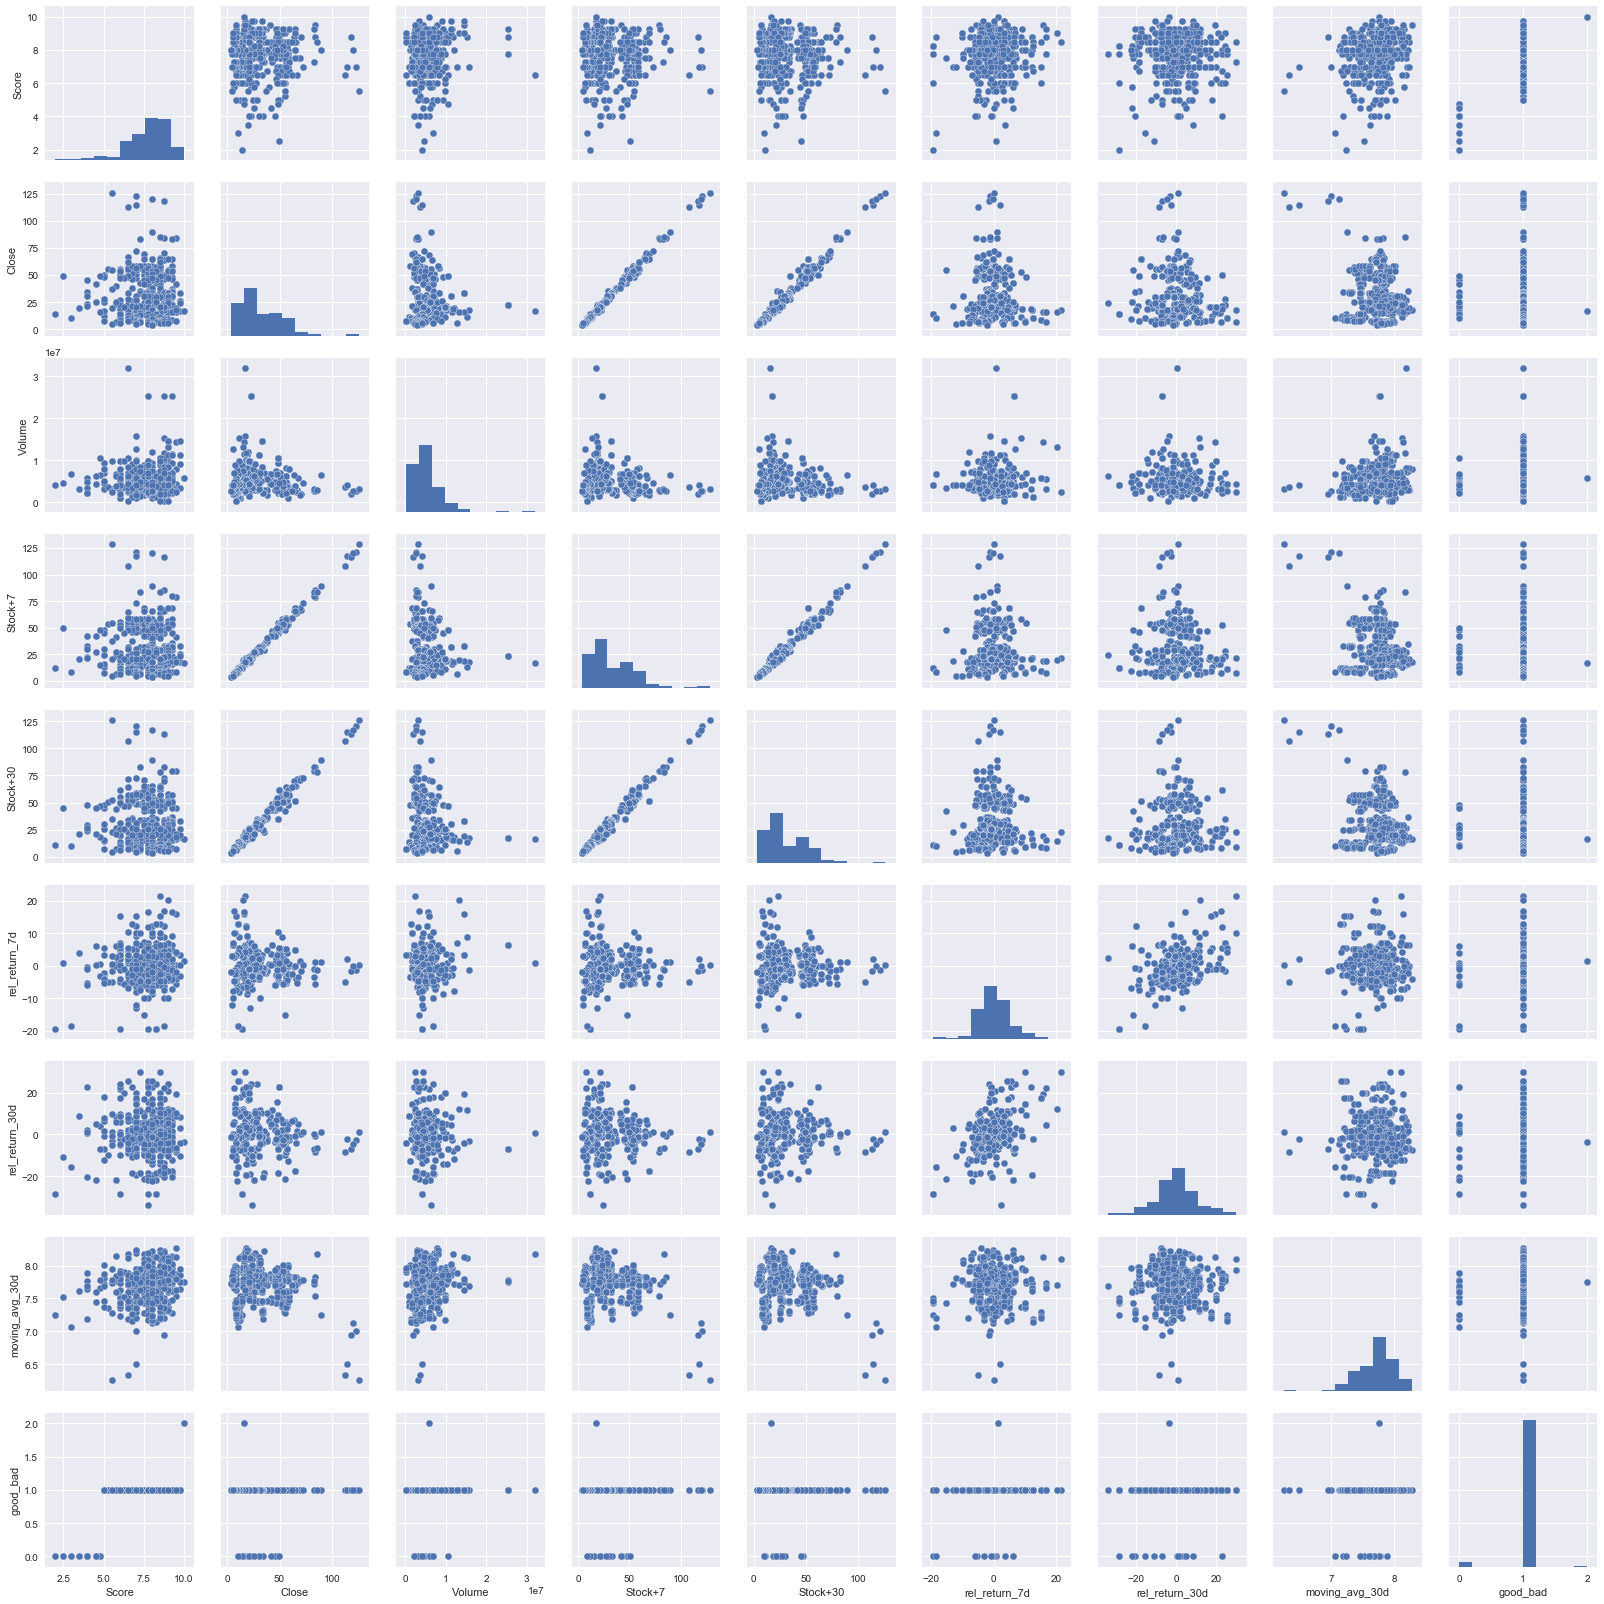

In [294]:
#pairwise relationships
sns.pairplot(data)

Text(0.5,1,'Reviews since 1994')

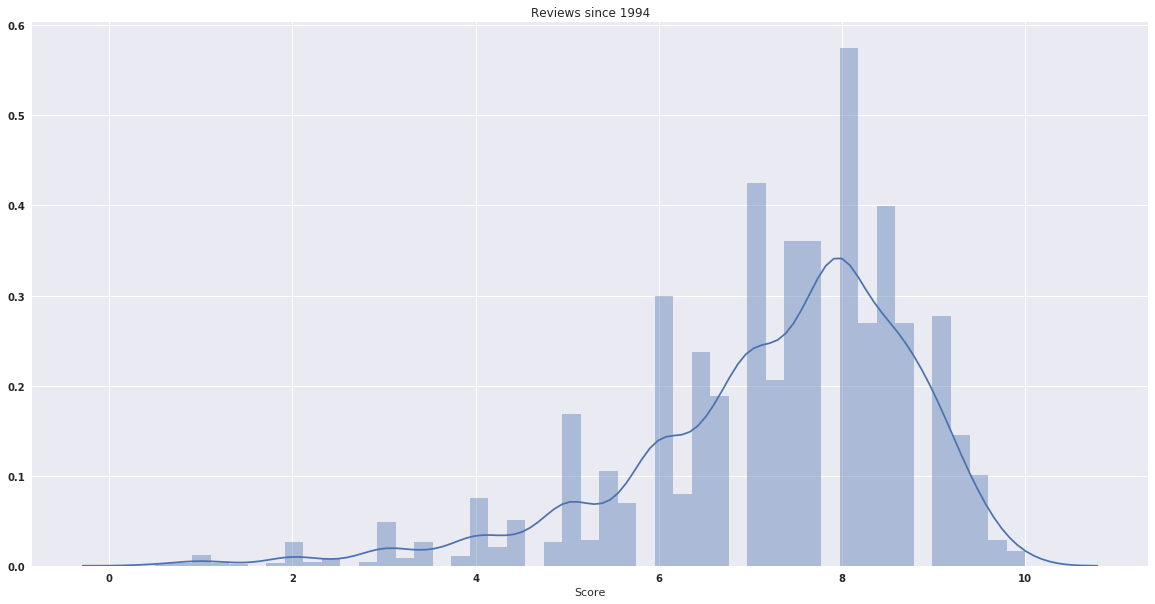

In [772]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 48}
plt.rc('font', **font)
plt.figure(figsize=(20,10))
sns.distplot(clean_reviews["Score"])
#KDE line (kernel density estimation) of P(score); 
#inferences about the population are made, based on tbe finite data sample.
plt.title("Reviews since 1994") #since1994 #Reason to be suspicious

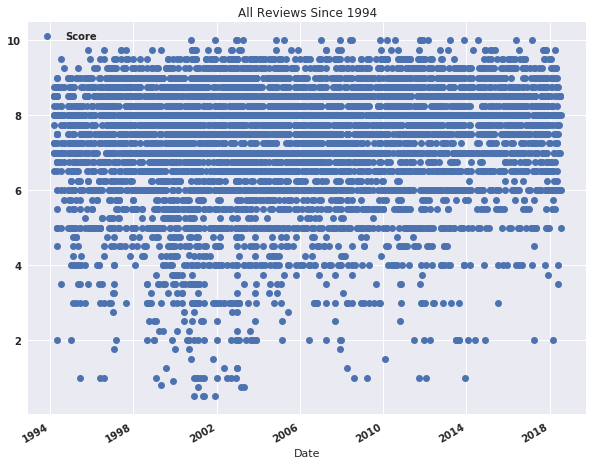

In [773]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}
plt.rc('font', **font)
clean_reviews.plot(x="Date", y="Score", style="o", figsize=(10,8), title='All Reviews Since 1994')
plt.show()

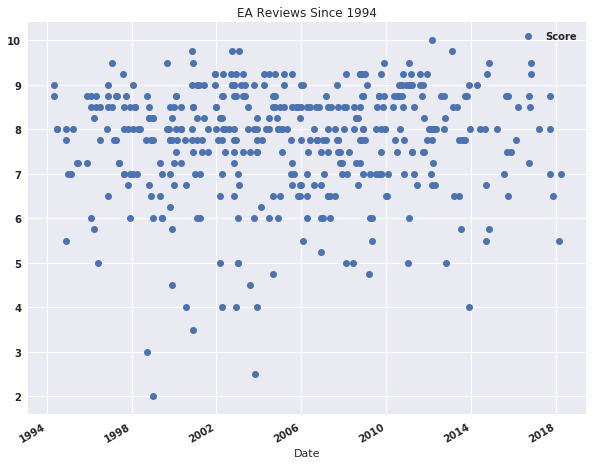

In [775]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}
plt.rc('font', **font)
data.plot(x='Date', y='Score', style="o", figsize=(10,8), title='EA Reviews Since 1994')
plt.show()

In [563]:
#clean_reviews['Score'].dropna(inplace=True) !!!THIS DOESN'T WORK!!! 
#GOOD READ: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
clean_reviews['Score']=clean_reviews.loc[:,('Score')].dropna()

0

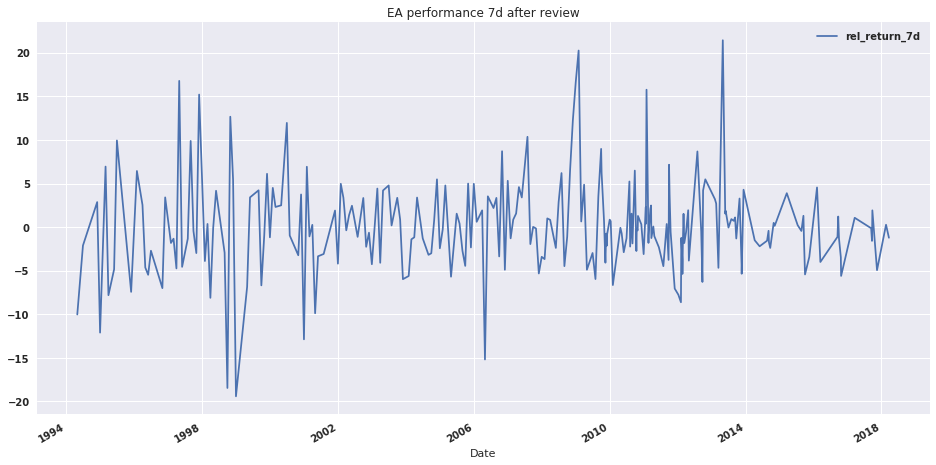

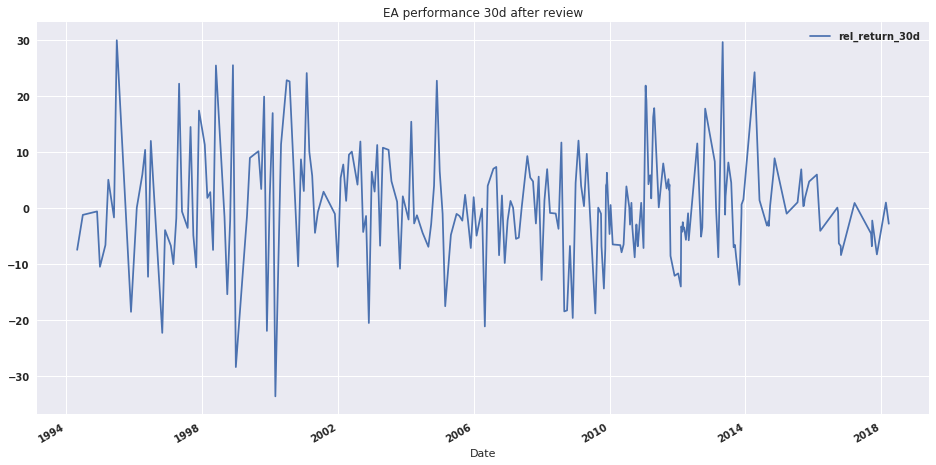

In [776]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}
plt.rc('font', **font)
data.plot(x='Date', y='rel_return_7d', figsize=(16,8), title='EA performance 7d after review')
data.plot(x='Date', y='rel_return_30d', figsize=(16,8), title='EA performance 30d after review')
#Recent years indicate tighter returns around weekly reviews
plt.show()

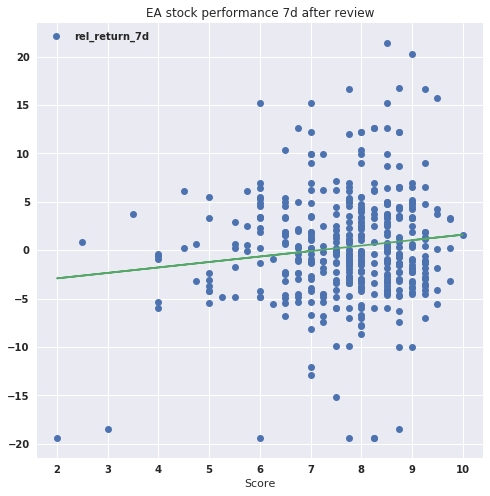

In [777]:
#EA stock seems to perform well the week after review
#Scores below 6 tend to show negative reviews
#but the skew of the scores becomes apparent at the higher end
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}
plt.rc('font', **font)
from numpy.polynomial.polynomial import polyfit
data.plot(x='Score', y='rel_return_7d', style="o", figsize=(8,8), title='EA stock performance 7d after review')

b, m = polyfit(data.Score, data.rel_return_7d, 1)
plt.plot(data.Score, b + m * data.Score, '-')
plt.show()

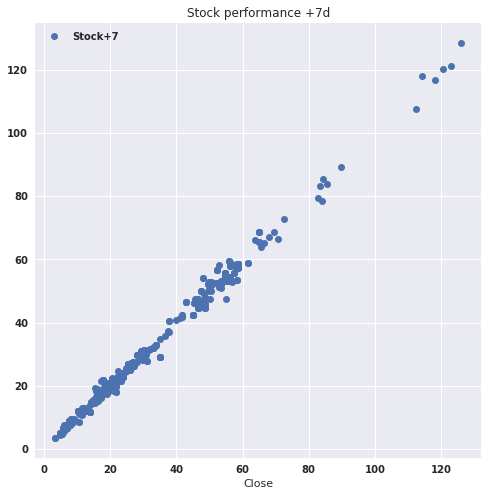

In [778]:
#but today's stock price is an essential input for the forward price
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}
plt.rc('font', **font)
data.plot(x='Close', y='Stock+7', style="o", figsize=(8,8), title='Stock performance +7d')
plt.show()

In [220]:
#correlations
data.corr()

,Score,Close,Volume,Stock+7,Stock+30,rel_return_7d,rel_return_30d,moving_avg_30d,good_bad
Score,1.000000,-0.038794,0.072029,-0.037856,-0.047826,0.124090,0.005673,0.234395,0.556600
Close,-0.038794,1.000000,-0.151503,0.996096,0.986054,-0.080218,-0.118032,-0.294606,0.010702
Volume,0.072029,-0.151503,1.000000,-0.151281,-0.149894,0.044600,-0.000719,0.186833,0.012299
Stock+7,-0.037856,0.996096,-0.151281,1.000000,0.988424,-0.018964,-0.093133,-0.304715,0.015803
Stock+30,-0.047826,0.986054,-0.149894,0.988424,1.000000,-0.041306,0.008719,-0.294734,0.015427
rel_return_7d,0.124090,-0.080218,0.044600,-0.018964,-0.041306,1.000000,0.392548,-0.017068,0.110617
rel_return_30d,0.005673,-0.118032,-0.000719,-0.093133,0.008719,0.392548,1.000000,0.038036,0.070169
moving_avg_30d,0.234395,-0.294606,0.186833,-0.304715,-0.294734,-0.017068,0.038036,1.000000,0.104125
good_bad,0.556600,0.010702,0.012299,0.015803,0.015427,0.110617,0.070169,0.104125,1.000000


## Distribution of target variables appears normal

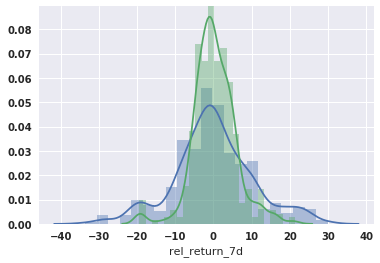

In [781]:

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}
sns.distplot(data['rel_return_30d'])
sns.distplot(data['rel_return_7d'])
plt.show()

## Baseline model & OLS regression summary stats

In [815]:
X=data.loc[:,['Close']]
y=data['Stock+30']
#note 7d data is to tightly coorelated (R .99) to analyze potential effects of GameInformer reviews
model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Stock+30   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.506e+04
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:51:01   Log-Likelihood:                -1148.0
No. Observations:                 431   AIC:                             2300.
Df Residuals:                     429   BIC:                             2308.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6673      0.303      2.204      0.028       0.072       1.262
Close          0.9743      0.008    122.720      0.000       0.959       0.990
==============================================================================
Omnibus:                       82.953   Durbin-Watson:                   0.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.085
Skew:                          -0.821   Prob(JB):                     9.31e-67
Kurtosis:                       6.773   Cond. No.                         68.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Do features contribute to fit?.... R**2 unchanged at 0.972

In [816]:
X=data.loc[:,['Score','Volume',"moving_avg_30d", 'Close']]
y=data['Stock+30']

model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Stock+30   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3752.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        13:51:05   Log-Likelihood:                -1147.3
No. Observations:                 431   AIC:                             2305.
Df Residuals:                     426   BIC:                             2325.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3218      5.044      0.659      0.511      -6.593      13.237
Score             -0.1519      0.139     -1.093      0.275      -0.425       0.121
Volume          2.803e-09   5.01e-08      0.056      0.955   -9.56e-08    1.01e-07
moving_avg_30d    -0.1900      0.665     -0.286      0.775      -1.497       1.117
Close              0.9733      0.008    116.253      0.000       0.957       0.990
==============================================================================
Omnibus:                       80.956   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.261
Skew:                          -0.805   Prob(JB):                     3.44e-64
Kurtosis:                       6.699   Cond. No.                     1.90e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Build a Hold Out Set to test different Models

In [817]:
#build hold out set to test models
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=84)

#split into 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

### Baseline: Linear Regression

In [818]:
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
print(lin_reg_est.fit(X_train, y_train))

[0.9897972  0.94579378 0.96819762 0.98439133 0.96200828]
Linear Reg Mean Score:  0.9700376407882384
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


## Moving to polynomial features

In [819]:
lin_reg_est.score(X_holdout, y_holdout)

0.9527607447274146

In [820]:
X_holdout.shape

(44, 4)

In [821]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

In [822]:
poly = PolynomialFeatures(degree=2) #R^2 worse for higher degrees

lm_poly = LinearRegression()
X_train = poly.fit_transform(X_train)
lm_poly.fit(X_train, y_train)
# y_pred = lm_poly.predict()
X_holdout = poly.transform(X_holdout)
print("Polynomial Regression:", lm_poly.score(X_holdout, y_holdout))
print("Polynomial Regression:", lm_poly.score(X_train, y_train))

Polynomial Regression: 0.9537367020139593
Polynomial Regression: 0.9759114340367545


In [824]:
results = lm_poly.fit(X_train,y_train)
results.summary()

AttributeError: 'LinearRegression' object has no attribute 'summary'

## Evaluating model

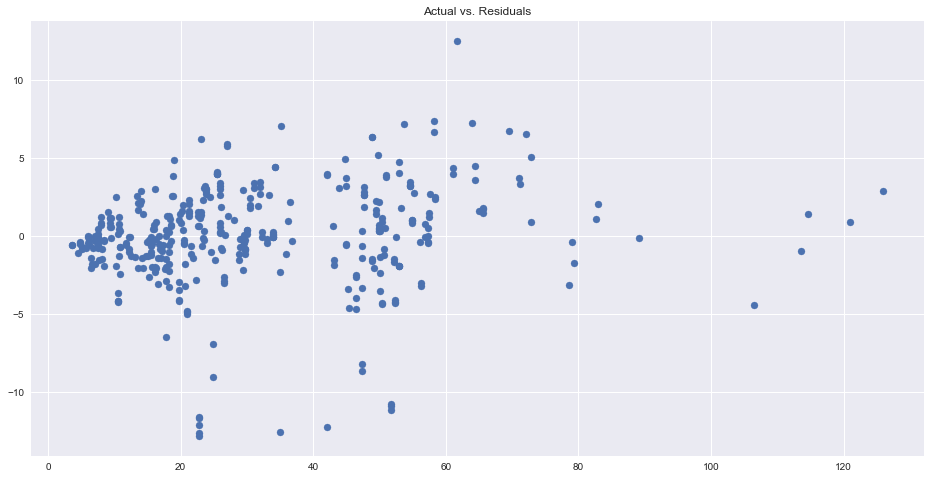

In [736]:
y_train_pred = lm_poly.predict(X_train)
poly_residuals = y_train - y_train_pred
plt.figure(figsize=(16,8))
plt.title("Actual vs. Residuals")
plt.scatter(y_train, poly_residuals)
plt.show()

In [336]:
data.to_csv('data.csv',index=False)

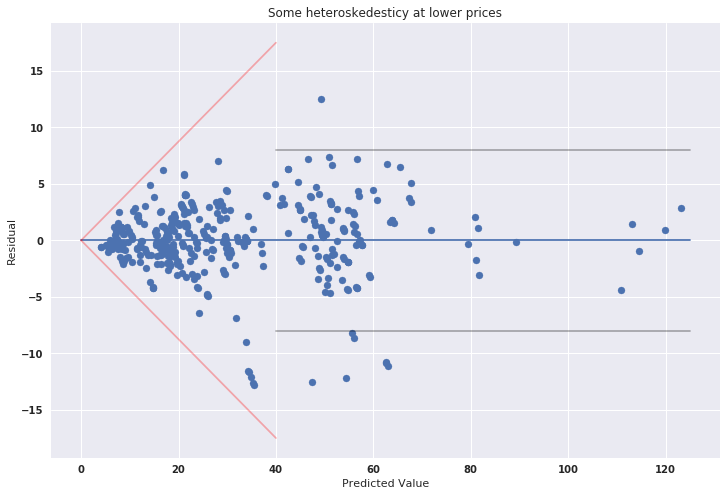

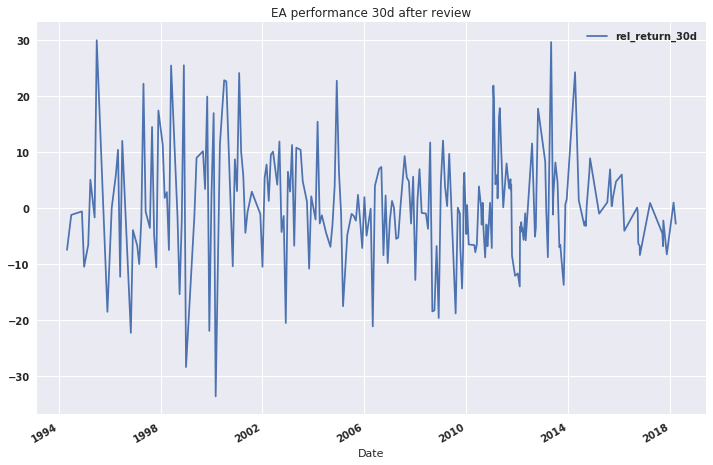

In [809]:
plt.figure(figsize=(12,8))
plt.scatter(y_train_pred,y_train-y_train_pred)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.title('Some heteroskedesticy at lower prices')
#Some Heteroskedesticity at lower range of closing prices
#The model improves at higher range
#recall...
plt.plot(np.linspace(0,125,2),np.linspace(0,0,2))
plt.plot(np.linspace(0,40,2),np.linspace(0,17.5,2),color='r',alpha=0.3)
plt.plot(np.linspace(0,40,2),np.linspace(0,-17.5,2), color='r',alpha=0.3)
plt.plot(np.linspace(40,125,2),np.linspace(8,8,2),color='k', alpha=0.3)
plt.plot(np.linspace(40,125,2),np.linspace(-8,-8,2), color='k',alpha=0.3)
data.plot(x='Date', y='rel_return_30d', figsize=(12,8), title='EA performance 30d after review')
#Recent years indicate tighter returns around weekly reviews
plt.show()

# Challenges 5

### Linear Regression and Train/Test Split challenges


#### Challenge 1

Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

In [141]:
data['constant']=1 

In [175]:
X = data[['constant']].values
y = data[['rel_return_30d']].values
model = sm.OLS(y,X)
results = model.fit()
results.summary()

/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Tue, 24 Jul 2018   Prob (F-statistic):                nan
Time:                        11:57:29   Log-Likelihood:                -1624.9
No. Observations:                 431   AIC:                             3252.
Df Residuals:                     430   BIC:                             3256.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0147      0.506      0.029      0.977      -0.980       1.010
==============================================================================
Omnibus:                        5.157   Durbin-Watson:                   0.962
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                6.914
Skew:                           0.022   Prob(JB):                       0.0315
Kurtosis:                       3.619   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The results imply that rel_return_30d will rise 0.015 pts for every pt change in X(constant). Doesn't make any real sense in this context but it attempts to predict the return prices.

#### Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

ValueError: shapes (431,1) and (431,1) not aligned: 1 (dim 1) != 431 (dim 0)

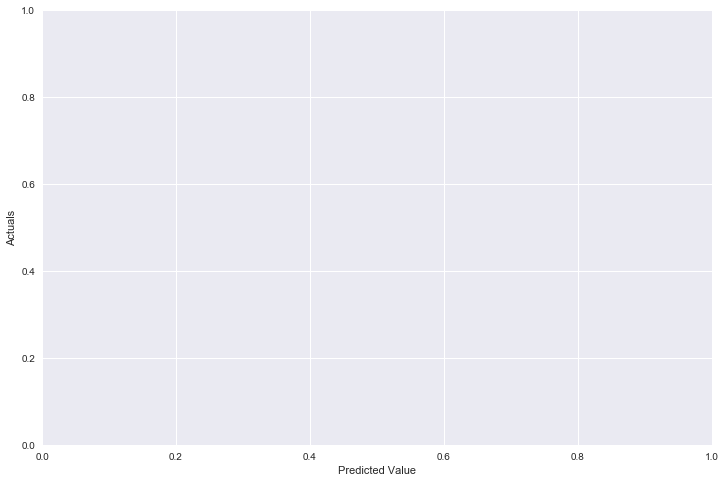

In [176]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted Value')
plt.ylabel('Actuals')

y_pred = model.predict(X)

plt.scatter(y,y_pred)
plt.title("Predictions vs Actual")
plt.show()

#### Challenge 2

Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?


#### Challenge 3

Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?


#### Challenge 4

Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.


#### Challenge 5

Fitting and checking predictions on the exact same data set can be
misleading. Divide your data into two sets: a training and a test set
(roughly 75% training, 25% test is a fine split). Fit a model on the
training set, check the predictions (by plotting versus actual values)
in the test set.